# 130. Neural machine translation with a Transformer and Keras

이 튜토리얼은 Transformer 모델 을 학습시켜 포르투갈어를 영어 데이터 세트 로 번역합니다. 이것은 텍스트 생성 및 Attention 에 대한 지식을 가정한 고급 예제입니다.

Transformer 모델의 핵심 아이디어는 self-attention (입력 시퀀스의 표현을 계산하기 위해 입력 시퀀스의 다른 위치에 주의를 기울이는 기능)입니다. Transformer는 self-attention 레이어의 스택을 생성하고 아래의 Scaled dot product Attention 및 Multi-head Attention 섹션에서 설명됩니다.

<img src="https://www.tensorflow.org/images/tutorials/transformer/apply_the_transformer_to_machine_translation.gif" alt="Applying the Transformer to machine translation">

Figure 1:Transformer를 기계 번역에 적용합니다.


이 튜토리얼에서는 다음을 수행합니다.

- 데이터 준비  
- 필요한 구성요소 구현:  
   - 위치 임베딩.  
   - Attention layer.  
   - 인코더와 디코더.  
- Transformer를 제작 및 훈련  .
- 번역 생성  

이 튜토리얼에서는  4층 Transformer를 구축합니다.

이 노트북에서 모델을 훈련한 후에는 포르투갈어 문장을 입력하고 영어 번역을 반환할 수 있습니다.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" alt="Attention heatmap">

Figure 2: 이 튜토리얼이 끝나면 생성할 수 있는 시각화된 Attention 가중치.

## Setup

In [2]:
# 현재의 tensorflow version 삭제
!pip uninstall --y tensorflow

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0


In [3]:
# tensorflow version downgrade
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installatio

In [5]:
# downgrade 되었는지 확인
import tensorflow as tf
print(tf.__version__)

2.15.0


In [6]:
# Downgrade된 TensorFlow의 버전에 맞는 package 설치
# `tf.keras.layers.MultiHeadAttention`에 대한 마스킹 지원.

!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
# Install the compatible cuDNN version for CUDA 11.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

# Uninstall existing TensorFlow and related packages
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text

# Install the required protobuf version
!pip install protobuf~=3.20.3

# Install TensorFlow Datasets
!pip install -q tensorflow_datasets

# Install TensorFlow 2.15.0 and TensorFlow Text 2.15.0
!pip install -q -U tensorflow-text==2.15.0

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.5 MB/s eta 0:00:00


In [7]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

## 데이터 처리

이 섹션에서는 데이터 세트와 하위 단어 토크나이저를 다운로드하고 훈련을 위해 `tf.data.Dataset`에 래핑합니다.

### Download the dataset

TensorFlow 데이터세트를 사용하여 포르투갈어-영어 번역 데이터세트를 로드합니다. 이 데이터 세트에는 약 52,000개의 훈련, 1,200개의 검증 및 1,800개의 테스트 예제가 포함되어 있습니다.

In [8]:
# 'ted_hrlr_translate/pt_to_en' 데이터셋 로드
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

# 훈련 및 검증 예제 분리
train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.91E14I_1.0.0/ted_hrlr_translate-tra…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.91E14I_1.0.0/ted_hrlr_translate-val…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.91E14I_1.0.0/ted_hrlr_translate-tes…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


TensorFlow Datasets에서 반환된 `tf.data.Dataset` 객체는 텍스트 예제 쌍을 생성합니다.

In [9]:
# 훈련 데이터셋에서 포르투갈어 및 영어 예제 출력
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> 포르투갈어 예제:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))  # 포르투갈어 문장 디코딩하여 출력
  print()

  print('> 영어 예제:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))  # 영어 문장 디코딩하여 출력

> 포르투갈어 예제:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> 영어 예제:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


### Tokenizer Set up

이제 데이터세트를 로드했으므로 각 요소가 토큰 ID(a)로 표시되도록 텍스트를 토큰화해야 합니다.

이 튜토리얼에서는 [서브워드 토크나이저](https://www.tensorflow.org/text/guide/subwords_tokenizer) 튜토리얼에 내장된 토크나이저를 사용합니다.

In [10]:
# 'ted_hrlr_translate_pt_en_converter' 모델 다운로드 및 압축 해제
model_name = 'ted_hrlr_translate_pt_en_converter'

tf.keras.utils.get_file(
    f'{model_name}.zip',  # 저장할 파일 이름
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',  # 다운로드 URL
    cache_dir='.',       # 캐시 디렉토리 위치
    cache_subdir='',     # 캐시 서브디렉토리 위치
    extract=True         # 파일 압축 해제
)

184801/184801 [==============================] - 1s 3us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [11]:
# 저장된 모델 로드
tokenizers = tf.saved_model.load(model_name)

`tf.saved_model`에는 두 개의 텍스트 토크나이저가 포함되어 있습니다. 하나는 영어용이고 다른 하나는 포르투갈어용입니다. 둘 다 동일한 방법을 사용합니다.

In [12]:
# tokenizers.en 객체의 사용 가능한 메소드와 속성 리스트 출력
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

`tokenize` 메서드는 문자열 배치를 패딩된 토큰 ID 배치로 변환합니다. 이 방법은 토큰화하기 전에 입력을 구두점, 소문자로 나누고 유니코드 정규화합니다.

In [13]:
# TensorFlow 데이터셋에서 로드한 배치의 영어 문장 출력
for en in en_examples.numpy():
  print(en.decode('utf-8'))   # 영어 문장을 UTF-8로 디코딩하여 출력

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [14]:
# 로드된 토크나이저를 사용하여 영어 문장을 토큰 ID로 변환
encoded = tokenizers.en.tokenize(en_examples)

# 패딩된 토큰 ID의 배치 출력
for row in encoded.to_list():
  print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


`detokenize` 메소드는 이러한 토큰 ID를 사람이 읽을 수 있는 텍스트로 다시 변환 합니다.

In [15]:
# 토큰 ID를 다시 사람이 읽을 수 있는 텍스트로 변환
round_trip = tokenizers.en.detokenize(encoded)

# 변환된 텍스트 출력
for line in round_trip.numpy():
  print(line.decode('utf-8'))    # 텍스트를 UTF-8로 디코딩하여 출력

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


하위 수준 `lookup` 메서드는 토큰 ID를 토큰 텍스트로 변환합니다.

In [16]:
# 토큰 ID를 다시 개별 토큰으로 변환
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

출력은 하위 단어 토큰화의 "subword" 측면을 보여줍니다.

예를 들어 'searchability''라는 단어는 'search''와 ''##ability''로 분해되고, 'serendipity''라는 단어는 ''s'', ''##ere'', ``##nd'`, ``##ip'` 및 ``##ity'`로 분해됩니다.

토큰화된 텍스트에는 `'[START]'` 및 `'[END]'` 토큰이 포함되어 있습니다.

"Transformer is awesome."을 tokenize 하면 다음과 같습니다.

In [17]:
sample_string = tf.constant(['Transformer is awesome.'])

tokenized_string = tokenizers.en.tokenize(sample_string)

print(tokenized_string.numpy())
print(tokenizers.en.lookup(tokenized_string))
print(tokenizers.en.detokenize(tokenized_string).numpy())

[[   2 1761  227   80 1920   15    3]]
<tf.RaggedTensor [[b'[START]', b'transform', b'##er', b'is', b'awesome', b'.', b'[END]']]>
[b'transformer is awesome .']


데이터 세트의 example당 토큰 분포는 다음과 같습니다.

In [18]:
# 포르투갈어와 영어 문장들의 토큰 개수를 저장할 리스트
lengths = []

# 훈련 데이터셋의 배치를 순회하며 토큰 개수 계산
for pt_examples, en_examples in train_examples.batch(1024):
  # 포르투갈어 문장 토큰화 및 토큰 개수 저장
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())

  # 영어 문장 토큰화 및 토큰 개수 저장
  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())

  print('.', end='', flush=True)  # 진행 상태 표시

...................................................

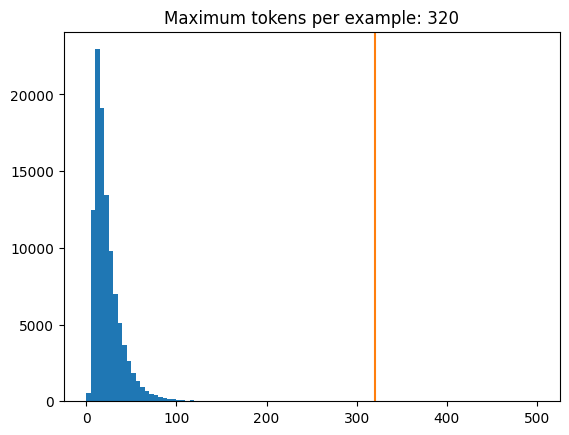

In [19]:
# 모든 토큰 개수를 하나의 배열로 결합
all_lengths = np.concatenate(lengths)

# 히스토그램으로 토큰 개수 분포 시각화
plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())

# 가장 긴 문장의 토큰 개수 표시
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())

# 그래프 제목 설정
plt.title(f'Maximum tokens per example: {max_length}');

### `tf.data`를 사용하여 데이터 파이프라인 설정

다음 함수는 텍스트 배치를 입력으로 사용하여 훈련에 적합한 형식으로 변환합니다.

1. 텍스트 배치를  ragged batch로 토큰화합니다.
2. `MAX_TOKENS`보다 길지 않도록 자릅니다.  
3. 대상(영어) 토큰을 입력과 레이블로 분할합니다. 이는 각 입력 위치에서 '레이블'이 다음 토큰의 ID가 되도록 한 단계씩 이동됩니다.  
4. `RaggedTensor`를 패딩된 dense `Tensor`로 변환합니다.  
5. `(inputs, labels)` 쌍을 반환합니다.  

"Ragged batch"는 TensorFlow에서 사용되는 용어로, 각 요소의 길이가 서로 다른 배치를 의미합니다. 이는 특히 자연어 처리에서 문장 또는 문서의 길이가 서로 다를 때 이를 표현하기 위해 사용됩니다.
 RaggedTensor는 이러한 가변 길이 시퀀스를 효율적으로 저장하고 처리할 수 있도록 설계되었습니다.

In [20]:
print(tokenized_string)   # Ragged Tensor
print(tokenized_string.to_tensor())

<tf.RaggedTensor [[2, 1761, 227, 80, 1920, 15, 3]]>
tf.Tensor([[   2 1761  227   80 1920   15    3]], shape=(1, 7), dtype=int64)


In [21]:
MAX_TOKENS = 128

def prepare_batch(pt, en):
    # 포르투갈어 문장 토큰화 및 최대 토큰 수에 맞게 잘라내기
    pt = tokenizers.pt.tokenize(pt)  # Output is ragged.
    pt = pt[:, :MAX_TOKENS]  # MAX_TOKENS로 잘라내기
    pt = pt.to_tensor()              # 0으로 패딩된 밀집 텐서로 변환

    # 영어 문장 토큰화 및 최대 토큰 수에 맞게 잘라내기
    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # [END] 토큰 제거
    en_labels = en[:, 1:].to_tensor()   # [START] 토큰 제거

    return (pt, en_inputs), en_labels

아래 함수는 텍스트 예제 데이터 세트를 학습용 배치 데이터로 변환합니다.

1. 텍스트를 토큰화하고 너무 긴 시퀀스를 필터링합니다.  
2. `cache` 메소드는 해당 작업이 한 번만 실행되도록 보장합니다.  
3. 그런 다음 `shuffle` 및 `dense_to_ragged_batch`를 통해 순서를 무작위로 지정하고 예제 배치를 어셈블합니다.  
4. 마지막으로 'prefetch'는 모델과 병렬로 데이터세트를 실행하여 필요할 때 데이터를 사용할 수 있도록 합니다.

In [24]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [25]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)  # 데이터셋을 섞음
      .batch(BATCH_SIZE)     # 배치 크기로 나눔
      .map(prepare_batch, tf.data.AUTOTUNE)  # 각 배치에 대해 prepare_batch 함수 적용
      .prefetch(buffer_size=tf.data.AUTOTUNE))  # 데이터를 사전에 가져와 성능 향상

 </section>

## Dataset 테스트

In [26]:
# 훈련 및 검증 데이터셋을 배치로 변환
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

Keras `Model.fit` train 에서는 `(입력, 레이블)` 쌍을 예상합니다.
`입력`은 토큰화된 포르투갈어 및 영어 시퀀스 쌍 `(pt, en)`입니다.
'레이블'은 1만큼 이동된 동일한 영어 시퀀스입니다.
이러한 변화는 각 위치에서 다음 토큰의 'label'인 'en' 시퀀스를 입력하도록 하기 위한 것입니다.

<table>
<tr>
  <th>Inputs at the bottom, labels at the top.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

이 설정은 각 단계의 모델 출력에 관계없이 다음 단계의 입력으로 실제 값을 얻기 때문에 "teacher forcing"이라고 합니다.
이는 텍스트 생성 모델을 교육하는 간단하고 효율적인 방법입니다.
모델을 순차적으로 실행할 필요가 없고, 서로 다른 시퀀스 위치의 출력을 병렬로 계산할 수 있으므로 효율적입니다.

포르투갈어 시퀀스가 주어지면 모델은 영어 시퀀스를 생성하려고 시도합니다.  

추론 루프를 작성하고 모델의 출력을 입력으로 다시 전달해야 합니다.  
모델은 훈련 중에 자체 오류를 수정하는 방법을 배워야 하기 때문에 보다 안정적인 모델을 제공할 수 있습니다.

In [27]:
# 훈련 배치의 첫 번째 요소 가져오기
for (pt, en), en_labels in train_batches.take(1):
  break

# 포르투갈어 입력, 영어 입력, 영어 레이블의 shape 출력
print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 128)
(64, 128)
(64, 128)


`en`과 `en_labels`는 동일하며 한자리만 shift 했습니다.

In [28]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([   2  186    9   55  184   71 5376  253   15    0], shape=(10,), dtype=int64)
tf.Tensor([ 186    9   55  184   71 5376  253   15    3    0], shape=(10,), dtype=int64)


## 구성 요소 정의

<table>
<tr>
  <th colspan=1>The original Transformer diagram</th>
  <th colspan=1>A representation of a 4-layer Transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>

### embedding 및 positional encoding layer

인코더와 디코더에 대한 입력은 동일한 임베딩 및 위치 인코딩 logic을 사용합니다.

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
  </td>
</tr>
</table>

일련의 토큰이 주어지면 입력 토큰(포르투갈어)과 대상 토큰(영어) 모두 `tf.keras.layers.Embedding` 레이어를 사용하여 벡터로 변환되어야 합니다.

모델 전체에 사용되는 Attention 레이어는 입력을 순서가 없는 벡터 집합으로 간주합니다. 모델에는 순환 또는 컨벌루션 레이어가 포함되어 있지 않기 때문에 단어 순서를 식별할 수 있는 방법이 필요합니다.

Transformer는 임베딩 벡터에 "위치 인코딩"을 추가합니다. 이는 (시퀀스 전반에 걸쳐) 서로 다른 주파수의 사인과 코사인 세트를 사용합니다.

논문에서는 위치 인코딩을 계산하기 위해 다음 공식을 사용합니다.

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [29]:
def positional_encoding(length, depth):
  depth = depth / 2  # 깊이를 절반으로 나눔

  # 각 위치에 대한 인덱스 생성
  positions = np.arange(length)[:, np.newaxis]          # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :] / depth  # (1, depth)

  # 각 깊이에 대한 각도 비율 계산
  angle_rates = 1 / (10000 ** depths)          # (1, depth)
  angle_rads = positions * angle_rates        # (pos, depth)

  # sin과 cos을 사용하여 위치 인코딩 생성
  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  # 결과를 TensorFlow 텐서로 변환
  return tf.cast(pos_encoding, dtype=tf.float32)

위치 인코딩 기능은 임베딩 벡터의 깊이를 따라 위치에 대해 서로 다른 주파수에서 진동하는 사인과 코사인의 스택입니다. position 축을 따라 진동합니다.

(2048, 512)


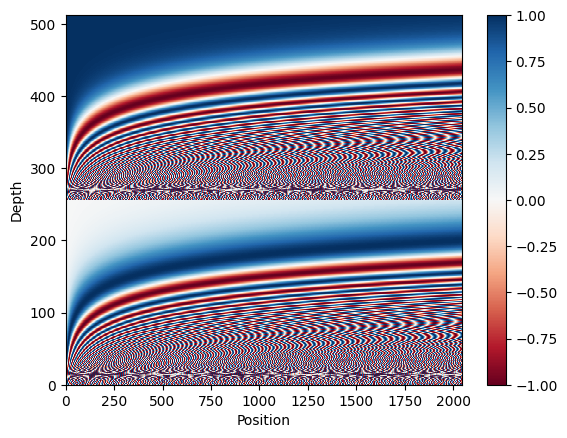

In [30]:
# 위치 인코딩 생성
pos_encoding = positional_encoding(length=2048, depth=512)

# 생성된 위치 인코딩의 형상 확인
print(pos_encoding.shape)  # (2048, 512)

# 위치 인코딩 시각화
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')  # 깊이에 따른 위치 인코딩 시각화
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()  # 컬러바 추가
plt.show()

따라서 이를 사용하여 토큰의 임베딩 벡터를 조회하고 위치 벡터를 추가하는 `PositionEmbedding` 레이어를 만듭니다.

In [31]:
#positional_encoding 함수는 길이가 2048, 깊이가 512인 위치 인코딩 행렬을 생성합니다.

class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model    # 임베딩 차원
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)  # 단어 임베딩 레이어
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)   # 위치 인코딩

  def compute_mask(self, *args, **kwargs):
    # 마스크 계산 (패딩된 부분을 모델이 무시하도록 함)
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]    # 입력 시퀀스의 길이
    x = self.embedding(x)    # 단어 임베딩 적용
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))    # 임베딩 크기 조정
    x = x + self.pos_encoding[tf.newaxis, :length, :]     # 위치 인코딩 추가
    return x

In [32]:
# 포르투갈어와 영어를 위한 위치 인코딩 임베딩 레이어 생성
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size().numpy(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size().numpy(), d_model=512)

# 포르투갈어 입력에 대한 임베딩 적용
pt_emb = embed_pt(pt)

# 영어 입력에 대한 임베딩 적용
en_emb = embed_en(en)

In [33]:
# 영어 임베딩 레이어의 마스크 속성 확인
en_emb._keras_mask

<tf.Tensor: shape=(64, 128), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

### Add and normalize

<table>
<tr>
  <th colspan=2>Add and normalize</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Add+Norm.png"/>
  </td>
</tr>
</table>

"Add & Norm" 블록은 모델 전체에 분산되어 있습니다. 각각은 잔차 연결을 결합하고 `LayerNormalization` 레이어를 통해 결합한 결과를 실행합니다.
잔차 연결은 그래디언트에 대한 직접적인 경로를 제공하며 정규화는 출력에 대한 합리적인 scale을 유지합니다.

### 기본 attention layer

Attention 레이어는 모델 전반에 걸쳐 사용됩니다. Attention이 구성되는 방식을 제외하고는 모두 동일합니다. 각각은 'layers.MultiHeadAttention', 'layers.LayerNormalization' 및 'layers.Add'를 포함합니다.

<table>
<tr>
  <th colspan=2>The base attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention.png"/>
  </td>
</tr>
</table>

- MultiHeadAttention: 다중 헤드 어텐션 메커니즘을 구현하는 레이어입니다. 이 레이어는 시퀀스 내의 각 위치가 다른 위치의 정보를 어떻게 참조하는지를 학습합니다.  
- LayerNormalization: 각 레이어의 출력을 정규화하는 레이어입니다. 이는 모델의 학습 안정성과 성능을 향상시킵니다.  
- Add: 두 입력을 더하는 레이어로, 여기서는 잔차 연결(residual connection)을 구현하는 데 사용됩니다.

In [34]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    # 다중 헤드 어텐션(MultiHeadAttention) 레이어 초기화
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)

    # 레이어 정규화(LayerNormalization) 레이어 초기화
    self.layernorm = tf.keras.layers.LayerNormalization()

    # 덧셈(Add) 레이어 초기화
    self.add = tf.keras.layers.Add()

#### Attention 작동 원리

<table>
<tr>
  <th colspan=1>The base attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention-new.png"/>
  </td>
</tr>
</table>

두 가지 입력이 있습니다.

1. query sequence; 처리 중인 시퀀스; attention을 하는 sequence(아래).
2. context sequence; attention 당하는 sequence(왼쪽).

출력은 쿼리 시퀀스와 동일한 모양을 갖습니다.

일반적인 비교는 이 작업이 dictionary 조회와 같다는 것입니다.
이 dictionary 조회는 '퍼지(fuzzy)'하고 '미분 가능(differentiable)'하며 '벡터화(vectorized)'된 형태의 사전 조회라고 할 수 있습니다.  
 '퍼지'는 모호하거나 불확실한 정보를 처리할 수 있다는 의미이며, '미분 가능'은 연산이 최적화 과정에서 그래디언트를 통해 학습될 수 있음을 의미합니다. '벡터화'는 연산이 전체 시퀀스에 대해 동시에 수행되며, 각 요소가 벡터 형태의 데이터로 처리된다는 것을 나타냅니다.

다음은 단일 쿼리에 3개의 키와 3개의 값이 전달되는 일반 Python 사전입니다.

```
d = {'color': 'blue', 'age': 22, 'type': 'pickup'}
result = d['color']
```

- 'query'는 당신이 찾으려는 것입니다.
- 'key'는 사전이 어떤 정보를 가지고 있는지를 나타냅니다.
- 'value'는 바로 그 정보입니다.

일반 dictionary에서 '쿼리'를 조회하면 dictionary는 일치하는 '키'를 찾아 관련 '값'을 반환합니다.  
키가 완벽하게 일치할 필요가 없는 **모호한(fuzzy)**한 dictionary를 상상할 수 있습니다.
위 사전에서 `d["species"]`를 검색했다면 검색어에 가장 잘 일치하는 `"pickup"`을 반환하기를 원할 수 있습니다.

Attention 레이어는 이와 같은 퍼지 조회를 수행하지만 단지 최상의 키를 찾는 것이 아닙니다.
'쿼리'가 각 '키'와 얼마나 잘 일치하는지에 따라 '값'을 결합합니다.

 Attention 레이어에서 '쿼리', '키', '값'은 각각 벡터입니다.
해시 조회를 수행하는 대신 어텐션 레이어는 '쿼리'와 '키' 벡터를 결합하여 이들이 얼마나 잘 일치하는지, 즉 "어텐션 점수"를 결정합니다.
레이어는 'attention score'에 따라 가중치를 적용하여 모든 '값'에 대한 평균을 반환합니다.

쿼리 시퀀스의 각 위치는 '쿼리' 벡터를 제공합니다.
컨텍스트 시퀀스는 사전 역할을 합니다. 컨텍스트 시퀀스의 각 위치에는 '키' 및 '값' 벡터가 제공됩니다.
입력 벡터는 직접 사용되지 않습니다. 'layers.MultiHeadAttention' 레이어에는 입력 벡터를 사용하기 전에 투영(projection)하기 위한 'layers.Dense' 레이어가 포함되어 있습니다.


### cross attention layer

Transformer의 문자 그대로 중심에는 Cross-Attention 레이어가 있습니다. 이 레이어는 인코더와 디코더를 연결합니다.

<table>
<tr>
  <th colspan=1>The cross attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention.png"/>
  </td>
</tr>
</table>

이를 구현하려면 `mha` 레이어를 호출할 때 대상 시퀀스 `x`를 `쿼리`로 전달하고 `컨텍스트` 시퀀스를 `key/value`로 전달합니다.

In [35]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    # 다중 헤드 어텐션을 쿼리, 키, 값에 적용
    attn_output, attn_scores = self.mha(
        query=x,            # 쿼리
        key=context,        # 키
        value=context,      # value
        return_attention_scores=True)  # 어텐션 점수 함께 반환

    # 어텐션 점수를 나중에 시각화하기 위해 저장
    self.last_attn_scores = attn_scores

    # 어텐션 출력과 입력을 더하고, 레이어 정규화 적용
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

아래 그림은 정보가 이 계층을 통해 어떻게 흐르는지 보여줍니다. 열은 컨텍스트 시퀀스에 대한 가중치 합계를 나타냅니다.

단순화를 위해 잔차 연결은 표시되지 않습니다.

<table>
<tr>
  <th>The cross attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
</table>

출력 길이는 'query' 시퀀스의 길이이며, 컨텍스트 'key/value' 시퀀스의 길이는 아닙니다.

아래 다이어그램은 더욱 단순화되었습니다. 전체 "attention score" 행렬을 그릴 필요는 없습니다.
요점은 각 'query' 위치가 컨텍스트의 모든 'key/value' 쌍을 볼 수 있지만 query 간에 정보가 교환되지는 않는다는 것입니다.

<table>
<tr>
  <th>Each query sees the whole context.</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new.png"/>
  </td>
</tr>
</table>

sample input을 시험삼아 수행해 봅니다.

In [36]:
# CrossAttention 레이어 예시 생성
sample_ca = CrossAttention(num_heads=2, key_dim=512)

# 포르투갈어와 영어 임베딩의 형상 출력
print(pt_emb.shape)  # 포르투갈어 임베딩 형상
print(en_emb.shape)  # 영어 임베딩 형상

# CrossAttention 레이어를 영어 및 포르투갈어 임베딩에 적용하고 결과 형상 출력
print(sample_ca(en_emb, pt_emb).shape)  # 교차 어텐션 적용 후 형상

(64, 128, 512)
(64, 128, 512)
(64, 128, 512)


### global self attention layer

이 계층은 컨텍스트 시퀀스를 처리하고 해당 길이에 따라 정보를 전파하는 역할을 담당합니다.

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png"/>
  </td>
</tr>
</table>

GlobalSelfAttention 클래스는 BaseAttention을 상속받아 구현됩니다.  
call 메소드는 레이어의 입력(x)을 받아 처리합니다. 여기서 self.mha는 다중 헤드 어텐션 레이어로, 쿼리(query), 키(key), 값(value) 모두 동일한 입력 x를 사용합니다. 이는 셀프 어텐션 메커니즘을 구현하는 것으로, 입력 시퀀스 내의 각 위치가 서로의 정보를 참조합니다.

In [37]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    # 셀프 어텐션: 쿼리, 키, 값 모두 동일한 입력 x를 사용
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)

    # 어텐션 결과와 원래 입력을 더함 (잔차 연결)
    x = self.add([x, attn_output])
    # 레이어 정규화 적용
    x = self.layernorm(x)

    return x

In [38]:
# GlobalSelfAttention 레이어 예시 생성
# num_heads=2, key_dim=512인 샘플 글로벌 셀프 어텐션 레이어(sample_gsa) 생성
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

# 포르투갈어 임베딩의 형상 출력
print(pt_emb.shape)  # 포르투갈어 임베딩 형상

# GlobalSelfAttention 레이어를 포르투갈어 임베딩에 적용하고 결과 형상 출력
print(sample_gsa(pt_emb).shape)  # 글로벌 셀프 어텐션 적용 후 형상

(64, 128, 512)
(64, 128, 512)


다음과 같이 그릴 수 있습니다.

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new-full.png"/>
  </td>
</tr>
</table>

잔여 연결은 생략되었습니다.
다음과 같이 그리는 것이 더 간결하고 정확합니다.

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new.png"/>
  </td>
</tr>
</table>

### causal self attention layer

이 레이어는 출력 시퀀스에 대해 global self attention 레이어와 유사한 작업을 수행합니다.

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention.png"/>
  </td>
</tr>
</table>

이는 인코더의 전역 self attention 레이어와 다르게 처리되어야 합니다.

CausalSelfAttention 클래스는 BaseAttention을 상속받아 구현됩니다. call 메소드는 레이어의 입력(x)을 받아 처리합니다. 여기서 self.mha는 다중 헤드 어텐션 레이어로, 쿼리(query), 키(key), 값(value) 모두 동일한 입력 x를 사용합니다. use_causal_mask=True는 인과적 마스크를 적용하여, 시퀀스의 각 위치가 그 이전 위치들의 정보만 참조하도록 합니다.

In [39]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    # 인과적 셀프 어텐션: 쿼리, 키, 값 모두 동일한 입력 x를 사용하며 인과적 마스크 적용
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask=True)  # 인과적 마스크 사용

    # 어텐션 결과와 원래 입력을 더함 (잔차 연결)
    x = self.add([x, attn_output])
    # 레이어 정규화 적용
    x = self.layernorm(x)

    return x

인과 마스크는 각 위치가 이전 위치만 액세스할 수 있도록 보장합니다.

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new-full.png"/>
  </td>
</tr>
</table>

이 레이어를 보다 간결하게 표현하면 다음과 같습니다.

<table>
</tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new.png"/>
  </td>
</tr>
</table>

layer 테스트:

CausalSelfAttention 클래스를 사용하여 num_heads=2, key_dim=512인 샘플 인과적 셀프 어텐션 레이어(sample_csa)를 생성합니다. en_emb는 영어 임베딩을 나타내며, 이의 형상을 출력하여 확인합니다. 그 후, sample_csa(en_emb)는 영어 임베딩에 인과적 셀프 어텐션 레이어를 적용합니다.

In [40]:
# CausalSelfAttention 레이어 예시 생성
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

# 영어 임베딩의 형상 출력
print(en_emb.shape)  # 영어 임베딩 형상

# CausalSelfAttention 레이어를 영어 임베딩에 적용하고 결과 형상 출력
print(sample_csa(en_emb).shape)  # 인과적 셀프 어텐션 적용 후 형상

(64, 128, 512)
(64, 128, 512)


초기 시퀀스 요소의 출력은 이후 요소에 의존하지 않으므로 레이어 적용 전 또는 후에 요소를 자르는지는 중요하지 않습니다.

In [41]:
# 첫 번째 방법: 입력 시퀀스의 첫 3개 토큰에 대해서만 인과적 셀프 어텐션 적용
out1 = sample_csa(embed_en(en[:, :3]))

# 두 번째 방법: 전체 입력 시퀀스에 인과적 셀프 어텐션을 적용하고 첫 3개 토큰의 결과만 추출
out2 = sample_csa(embed_en(en))[:, :3]

# 두 결과 간의 최대 차이 계산
tf.reduce_max(abs(out1 - out2)).numpy()

4.7683716e-07

### feed forward network

또한 transformer에는 인코더와 디코더 모두에 이 point-wise feed-forward network가 포함되어 있습니다.

<table>
<tr>
  <th colspan=1>The feed forward network</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>

네트워크는 중간에 ReLU 활성화가 있는 두 개의 선형 레이어(`tf.keras.layers.Dense`)와 드롭아웃 레이어로 구성됩니다. Attention 레이어와 마찬가지로 여기 코드에도 잔차 연결 및 정규화도 포함됩니다.

FeedForward 클래스는 Keras의 Layer 클래스를 상속받아 정의됩니다. 생성자(__init__)에서는 모델의 차원(d_model), 피드포워드 네트워크의 내부 차원(dff), 그리고 드롭아웃 비율(dropout_rate)을 받아 내부 레이어를 초기화합니다. 내부에는 두 개의 Dense 레이어와 드롭아웃 레이어가 순차적으로 구성됩니다.

call 메소드는 실제로 이 레이어가 입력 데이터 x에 적용되는 방식을 정의합니다. 여기서는 순차적 레이어 self.seq를 입력에 적용하고, 그 결과를 원래의 입력 x와 더하는 잔차 연결(residual connection)을 수행합니다. 그 후 레이어 정규화(self.layer_norm)를 적용하여 출력합니다.

In [42]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    # 순차적 레이어 정의: Dense -> Dense -> Dropout
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()                  # 덧셈 연산 레이어
    self.layer_norm = tf.keras.layers.LayerNormalization()  # 레이어 정규화

  def call(self, x):
    # 입력에 순차적 레이어 적용 후 원래 입력과 덧셈 (잔차 연결)
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)  # 정규화 적용
    return x

레이어를 테스트하면 출력은 입력과 모양이 동일합니다.

In [43]:
# FeedForward 레이어 예시 생성
sample_ffn = FeedForward(512, 2048)

# 영어 임베딩의 형상 출력
print(en_emb.shape)  # 영어 임베딩 형상

# FeedForward 레이어를 영어 임베딩에 적용하고 결과 형상 출력
print(sample_ffn(en_emb).shape)  # 피드포워드 네트워크 적용 후 형상

(64, 128, 512)
(64, 128, 512)


### encoder layer

인코더에는 'N' 인코더 레이어 스택이 포함되어 있습니다. 각 `EncoderLayer`에는 `GlobalSelfAttention` 및 `FeedForward` 레이어가 포함되어 있습니다.

<table>
<tr>
  <th colspan=1>The encoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png"/>
  </td>
</tr>
</table>

'EncoderLayer'의 정의는 다음과 같습니다.

In [44]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    # 글로벌 셀프 어텐션 레이어 초기화
    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,  # 어텐션 헤드 수
        key_dim=d_model,      # 키 차원
        dropout=dropout_rate) # 드롭아웃 비율

    # 피드포워드 네트워크 레이어 초기화
    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    # 글로벌 셀프 어텐션 적용
    x = self.self_attention(x)

    # 피드포워드 네트워크 적용
    x = self.ffn(x)

    return x

출력은 입력과 동일한 모양을 갖게 됩니다.

In [45]:
# EncoderLayer 레이어 예시 생성
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

# 포르투갈어 임베딩의 형상 출력
print(pt_emb.shape)  # 포르투갈어 임베딩 형상

# EncoderLayer 레이어를 포르투갈어 임베딩에 적용하고 결과 형상 출력
print(sample_encoder_layer(pt_emb).shape)  # 인코더 레이어 적용 후 형상

(64, 128, 512)
(64, 128, 512)


### encoder

다음으로 인코더를 빌드합니다.

<table>
<tr>
  <th colspan=1>The encoder</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Encoder.png"/>
  </td>
</tr>
</table>

인코더는 다음으로 구성됩니다.

- 입력의 'PositionalEmbedding' 레이어.
- 'EncoderLayer' 레이어 스택.

Encoder 클래스는 Keras의 Layer 클래스를 상속받아 정의됩니다. 생성자(__init__)에서는 모델의 차원(d_model), 인코더 레이어 수(num_layers), 어텐션 헤드의 수(num_heads), 피드포워드 네트워크 차원(dff), 어휘 사전 크기(vocab_size), 드롭아웃 비율(dropout_rate)을 받아 내부 레이어를 초기화합니다.  

call 메소드는 실제로 이 레이어가 입력 데이터 x에 적용되는 방식을 정의합니다. 먼저, 위치 임베딩 레이어를 적용한 후, 드롭아웃을 적용합니다. 그 후 각 인코더 레이어를 순차적으로 적용합니다.

In [46]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model  # 임베딩 차원
    self.num_layers = num_layers  # 인코더 레이어 수

    # 위치 임베딩 레이어 초기화
    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    # 인코더 레이어들을 리스트로 초기화
    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)  # 드롭아웃 레이어

  def call(self, x):
    # 입력 x는 토큰 ID (배치 크기, 시퀀스 길이)
    x = self.pos_embedding(x)  # 위치 임베딩 적용 (배치 크기, 시퀀스 길이, d_model)

    # 드롭아웃 적용
    x = self.dropout(x)

    # 각 인코더 레이어를 순차적으로 적용
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # 최종 출력 (배치 크기, 시퀀스 길이, d_model)

encoder 테스트:

4개의 레이어, 512차원의 모델, 8개의 어텐션 헤드, 2048차원의 피드포워드 네트워크, 그리고 8500 크기의 어휘 사전을 가진 샘플 인코더(sample_encoder)를 생성

In [47]:
# 인코더 인스턴스 생성
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

# 인코더에 포르투갈어 입력 적용
sample_encoder_output = sample_encoder(pt, training=False)

# 입력 및 출력 형상 출력
print(pt.shape)  # 포르투갈어 입력 형상
print(sample_encoder_output.shape)  # 인코더 출력 형상 (배치 크기, 입력 시퀀스 길이, d_model)

(64, 128)
(64, 128, 512)


### decoder layer

디코더의 스택은 약간 더 복잡하며 각 `DecoderLayer`에는 `CausalSelfAttention`, `CrossAttention` 및 `FeedForward` 레이어가 포함되어 있습니다.

<table>
<tr>
  <th colspan=1>The decoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png"/>
  </td>
</tr>
</table>

In [48]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,    # 모델의 차원
               num_heads,   # 어텐션 헤드의 수
               dff,                 # 피드포워드 네트워크 차원
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    # 인과적 셀프 어텐션 레이어 초기화
    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    # 교차 어텐션 레이어 초기화
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    # 피드포워드 네트워크 레이어 초기화
    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    # 인과적 셀프 어텐션 적용
    x = self.causal_self_attention(x=x)

    # 교차 어텐션 적용
    x = self.cross_attention(x=x, context=context)

    # 마지막 어텐션 점수를 시각화를 위해 저장
    self.last_attn_scores = self.cross_attention.last_attn_scores

    # 피드포워드 네트워크 적용
    x = self.ffn(x)  # 결과 형상: `(batch_size, seq_len, d_model)`
    return x

decoder layer 테스트:

In [49]:
# DecoderLayer 레이어 예시 생성
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

# 디코더 레이어에 영어 임베딩과 포르투갈어 임베딩 적용
sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

# 입력 및 출력 형상 출력
print(en_emb.shape)  # 영어 임베딩 형상
print(pt_emb.shape)  # 포르투갈어 임베딩 형상
print(sample_decoder_layer_output.shape)  # 디코더 레이어 출력 형상 (배치 크기, 시퀀스 길이, d_model)

(64, 128, 512)
(64, 128, 512)
(64, 128, 512)


### decoder

`Encoder`와 유사하게 `Decoder`는 `PositionalEmbedding`과 `DecoderLayer` 스택으로 구성됩니다.

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Decoder.png"/>
  </td>
</tr>
</table>

`tf.keras.layers.Layer`를 확장하여 디코더를 정의합니다.

In [50]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model    # 모델의 임베딩 차원
    self.num_layers = num_layers   # 디코더 레이어의 수

    # 위치 임베딩 레이어 초기화
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)  # 드롭아웃 레이어
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]  # 디코더 레이어 리스트

    self.last_attn_scores = None  # 마지막 어텐션 점수를 저장하는 변수

  def call(self, x, context):
    # 입력 x는 토큰 ID (배치 크기, 타겟 시퀀스 길이)
    x = self.pos_embedding(x)  # 위치 임베딩 적용

    x = self.dropout(x)  # 드롭아웃 적용

    # 각 디코더 레이어 순차적 적용
    for i in range(self.num_layers):
      x = self.dec_layers[i](x, context)

    # 마지막 레이어의 어텐션 점수 저장
    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # 최종 출력 형상: (배치 크기, 타겟 시퀀스 길이, d_model)
    return x

decoder 테스트:

In [51]:
# 디코더 인스턴스 생성
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

# 디코더에 영어 입력 데이터와 포르투갈어 임베딩 적용
output = sample_decoder(
    x=en,
    context=pt_emb)

# 입력 및 출력 형상 출력
print(en.shape)       # 영어 입력 데이터 형상
print(pt_emb.shape)   # 포르투갈어 임베딩 형상
print(output.shape)   # 디코더 출력 형상

(64, 128)
(64, 128, 512)
(64, 128, 512)


In [52]:
# 디코더의 마지막 어텐션 점수의 형상 확인
sample_decoder.last_attn_scores.shape  # (배치 크기, 어텐션 헤드 수, 타겟 시퀀스 길이, 입력 시퀀스 길이)

TensorShape([64, 8, 128, 128])

Transformer 인코더와 디코더를 만들었으면 이제 Transformer 모델을 구축하고 훈련할 차례입니다.

## Transformer

이제 'Encoder'와 'Decoder'가 생겼습니다. 'Transformer' 모델을 완성하려면 이들을 함께 모으고 각 위치의 결과 벡터를 출력 토큰 확률로 변환하는 최종 선형('Dense') 레이어를 추가해야 합니다.

디코더의 출력은 이 최종 선형 레이어의 입력입니다.

<table>
<tr>
  <th colspan=1>The transformer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
</tr>
</table>

인코더와 디코더는 각각 입력 어휘 사전 크기(input_vocab_size), 타겟 어휘 사전 크기(target_vocab_size), 레이어 수(num_layers), 모델 차원(d_model), 어텐션 헤드 수(num_heads), 피드포워드 네트워크 차원(dff), 드롭아웃 비율(dropout_rate)을 기반으로 설정됩니다.  

call 메소드는 모델의 입력 데이터 inputs를 받아 처리합니다. 입력은 컨텍스트(context)와 타겟 시퀀스(x)로 구성됩니다. 먼저 인코더를 통해 컨텍스트를 처리하고, 그 결과를 디코더에 전달하여 타겟 시퀀스를 처리합니다. 최종적으로, Dense 레이어(self.final_layer)를 통해 최종 출력(logits)을 계산합니다.

In [53]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    # 인코더 초기화
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    # 디코더 초기화
    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    # 최종 출력을 위한 Dense 레이어
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # 입력: 컨텍스트와 타겟 시퀀스
    context, x = inputs

    # 인코더를 통한 컨텍스트 처리
    context = self.encoder(context)  # (배치 크기, 컨텍스트 길이, d_model)

    # 디코더를 통한 타겟 시퀀스 처리
    x = self.decoder(x, context)  # (배치 크기, 타겟 길이, d_model)

    # 최종 출력 계산
    logits = self.final_layer(x)  # (배치 크기, 타겟 길이, 타겟 어휘 크기)

    # 필요 시 케라스 마스크 제거
    try:
      del logits._keras_mask
    except AttributeError:
      pass

    # 최종 출력 반환
    return logits

### Hyperparameters

이 예제를 작고 상대적으로 빠르게 유지하기 위해 레이어 수(`num_layers`), 임베딩의 차원(`d_model`), `FeedForward` 레이어의 내부 차원(`dff`)을 줄입니다. 원본 Transformer 문서에 설명된 기본 모델은 `num_layers=6`, `d_model=512` 및 `dff=2048`을 사용했습니다.

self-attention 헤드의 수는 동일하게 유지됩니다(`num_heads=8`).

In [54]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

'Transformer' 모델을 인스턴스화합니다.



In [55]:
# 트랜스포머 모델 인스턴스 생성
transformer = Transformer(
    num_layers=num_layers,               # 인코더 및 디코더 레이어 수
    d_model=d_model,                     # 임베딩 차원
    num_heads=num_heads,                 # 어텐션 헤드의 수
    dff=dff,                             # 피드포워드 네트워크의 차원
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),  # 포르투갈어 어휘 사전 크기
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(), # 영어 어휘 사전 크기
    dropout_rate=dropout_rate)           # 드롭아웃 비율

Test

In [56]:
# 트랜스포머 모델에 포르투갈어와 영어 입력 적용
output = transformer((pt, en))

# 입력 및 출력 형상 출력
print(en.shape)  # 영어 입력 데이터 형상
print(pt.shape)  # 포르투갈어 입력 데이터 형상
print(output.shape)  # 트랜스포머 모델 출력 형상

(64, 128)
(64, 128)
(64, 128, 7010)


In [57]:
# 트랜스포머 모델의 디코더에서 마지막 디코더 레이어의 어텐션 점수 확인
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (배치 크기, 어텐션 헤드 수, 타겟 시퀀스 길이, 입력 시퀀스 길이)

(64, 8, 128, 128)


In [58]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3632768   
                                                                 
 decoder_1 (Decoder)         multiple                  5647104   
                                                                 
 dense_38 (Dense)            multiple                  904290    
                                                                 
Total params: 10184162 (38.85 MB)
Trainable params: 10184162 (38.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training

### optimizer 설정

원래 Transformer [논문](https://arxiv.org/abs/1706.03762)의 공식에 따라 사용자 정의 학습률 스케줄러와 함께 Adam 최적화 프로그램을 사용합니다.

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

초기에는 학습률을 서서히 증가시키는 "웜업(warmup)" 기간을 거치며, 이후 학습률을 점차 감소시킵니다.

In [60]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model  # 모델 차원
    self.d_model = tf.cast(self.d_model, tf.float32)  # 모델 차원을 float32로 캐스팅

    self.warmup_steps = warmup_steps  # 웜업 스텝 수

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)  # 현재 스텝을 float32로 캐스팅
    arg1 = tf.math.rsqrt(step)  # 1 / sqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)  # step / (warmup_steps^1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)  # 학습률 계산

최적화 프로그램을 인스턴스화합니다(이 예에서는 `tf.keras.optimizers.Adam`입니다).

In [61]:
# 맞춤형 학습률 스케줄 생성
learning_rate = CustomSchedule(d_model)

# Adam 옵티마이저 초기화
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

사용자 정의 learning rate scheduler Test

Text(0.5, 0, 'Train Step')

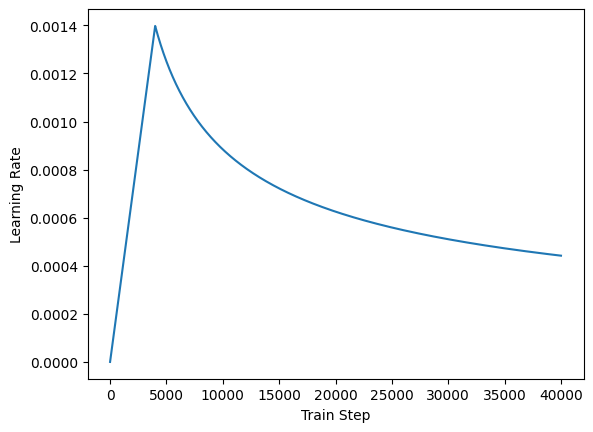

In [62]:
# 40000 스텝까지의 학습률 스케줄 시각화
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')  # y축 레이블: '학습률'
plt.xlabel('Train Step')    # x축 레이블: '훈련 스텝'

### loss and metric 설정

대상 시퀀스는 패딩되어 있으므로 손실을 계산할 때 패딩 마스크를 적용하는 것이 중요합니다. 교차 엔트로피 손실 함수(`tf.keras.losses.SparseCategoricalCrossentropy`)를 사용합니다.

masked_loss 함수는 레이블이 0인 부분(일반적으로 패딩 부분)을 마스크 처리하여 이 부분의 손실을 계산에서 제외합니다.

In [63]:
def masked_loss(label, pred):
  mask = label != 0   # 레이블이 0인 부분은 마스크 처리
  # SparseCategoricalCrossentropy 손실 함수 초기화
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  # 손실 계산
  loss = loss_object(label, pred)

  # 마스크를 손실의 데이터 타입으로 캐스팅
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask    # 마스크를 적용하여 불필요한 손실 제거

  # 마스크를 적용한 손실의 합을 마스크의 합으로 나누어 평균 손실 계산
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_accuracy(label, pred):
  # 예측값에서 가장 큰 값의 인덱스를 선택
  pred = tf.argmax(pred, axis=2)
  # 레이블을 예측값의 데이터 타입으로 캐스팅
  label = tf.cast(label, pred.dtype)
  # 예측값과 레이블이 일치하는지 여부
  match = label == pred

  mask = label != 0   # 레이블이 0인 부분은 마스크 처리

  # 마스크 적용하여 정확한 예측만 선택
  match = match & mask

  # 일치 여부와 마스크를 float 타입으로 캐스팅
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  # 마스크를 적용한 정확도의 합을 마스크의 합으로 나누어 평균 정확도 계산
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

### model Train

모든 구성 요소가 준비되면 `model.compile`을 사용하여 학습 절차를 구성한 다음 `model.fit`을 사용하여 실행합니다.

참고: Colab에서 학습하는 데 약 1시간이 걸립니다.

In [64]:
# 트랜스포머 모델 컴파일
transformer.compile(
    loss=masked_loss,             # 마스킹된 손실 함수
    optimizer=optimizer,          # 최적화 알고리즘
    metrics=[masked_accuracy])    # 마스킹된 정확도를 평가 지표로 사용

In [65]:
%%time

# 모델 훈련
transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)

Epoch 1/20
810/810 [==============================] - 225s 245ms/step - loss: 6.5954 - masked_accuracy: 0.1382 - val_loss: 5.0411 - val_masked_accuracy: 0.2448
Epoch 2/20
810/810 [==============================] - 185s 229ms/step - loss: 4.5739 - masked_accuracy: 0.2967 - val_loss: 4.1196 - val_masked_accuracy: 0.3455
Epoch 3/20
810/810 [==============================] - 186s 229ms/step - loss: 3.8297 - masked_accuracy: 0.3781 - val_loss: 3.4482 - val_masked_accuracy: 0.4303
Epoch 4/20
810/810 [==============================] - 185s 229ms/step - loss: 3.2868 - masked_accuracy: 0.4385 - val_loss: 3.0419 - val_masked_accuracy: 0.4845
Epoch 5/20
810/810 [==============================] - 185s 228ms/step - loss: 2.8979 - masked_accuracy: 0.4818 - val_loss: 2.7570 - val_masked_accuracy: 0.5170
Epoch 6/20
810/810 [==============================] - 186s 229ms/step - loss: 2.5810 - masked_accuracy: 0.5204 - val_loss: 2.4962 - val_masked_accuracy: 0.5534
Epoch 7/20
810/810 [====================

## 추론 실행

이제 변환을 수행하여 모델을 테스트할 수 있습니다. 추론에는 다음 단계가 사용됩니다.

* 포르투갈어 토크나이저(`tokenizers.pt`)를 사용하여 입력 문장을 인코딩합니다. 이것은 인코더 입력입니다.
* 디코더 입력은 `[START]` 토큰으로 초기화됩니다.
* 패딩 마스크와 미리 보기 마스크를 계산합니다.
* 그런 다음 `디코더`는 `인코더 출력`과 자체 출력(self-attention)을 보고 예측을 출력합니다.
* 예측된 토큰을 디코더 입력에 연결하고 디코더에 전달합니다.
* 이 접근 방식에서 디코더는 예측한 이전 토큰을 기반으로 다음 토큰을 예측합니다.

In [66]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers      # 토크나이저
    self.transformer = transformer  # 트랜스포머 모델

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # 입력 문장이 포르투갈어이므로 `[START]`와 `[END]` 토큰을 추가
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # 출력 언어가 영어이므로 영어 `[START]` 토큰으로 초기화
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # 동적 루프 추적을 위해 `tf.TensorArray` 사용
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # `seq_len` 차원에서 마지막 토큰 선택
      predictions = predictions[:, -1:, :]  # 형상: `(batch_size, 1, vocab_size)`

      predicted_id = tf.argmax(predictions, axis=-1)

      # `predicted_id`를 출력에 연결
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    text = tokenizers.en.detokenize(output)[0]  # 형상: `()`

    tokens = tokenizers.en.lookup(output)[0]

    # 루프의 마지막 반복에서 계산된 어텐션 가중치를 사용할 수 없으므로,
    # 루프 밖에서 다시 계산
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

'Translator' 클래스의 인스턴스를 만들고 몇 번 시도해 봅니다.

In [68]:
translator = Translator(tokenizers, transformer)

In [69]:
#함수는 세 가지 인자를 받습니다:
# sentence: 번역할 원문 문장
# tokens: 토큰화된 번역 결과입니다. 이 값은 numpy 배열로 변환되고 UTF-8로 디코딩됩니다.
# ground_truth: 실제 번역 결과
def print_translation(sentence, tokens, ground_truth):
  # 입력 문장 출력
  print(f'{"Input:":15s}: {sentence}')
  # 모델의 예측 번역 출력
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  # 실제 번역 (ground truth) 출력
  print(f'{"Ground truth":15s}: {ground_truth}')

Example 1:

In [70]:
# 포르투갈어 문장
sentence = 'este é um problema que temos que resolver.'
# 실제 번역 (ground truth)
ground_truth = 'this is a problem we have to solve .'

# Translator를 사용하여 포르투갈어 문장 번역
translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))

# 번역 결과 출력
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


Example 2:

In [71]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


Example 3:

In [72]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' ll soon share with you some stories of some magical things that happened .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


## attention plot 생성

이전 섹션에서 생성한 'Translator' 클래스는 모델의 내부 작업을 시각화하는 데 사용할 수 있는 attention 히트맵 dictionary를 반환합니다.

예를 들어:

In [73]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


토큰이 생성될 때 attention을 plot하는 함수를 만듭니다.

In [74]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # 모델이 출력에서 `<START>`를 생성하지 않았으므로 이를 생략합니다.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()  # 현재 축 가져오기
  ax.matshow(attention)  # 어텐션 맵 시각화
  ax.set_xticks(range(len(in_tokens)))  # x축 틱 설정
  ax.set_yticks(range(len(translated_tokens)))  # y축 틱 설정

  # 입력 토큰 레이블
  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(labels, rotation=90)  # x축 틱 레이블 설정 및 회전

  # 번역된 토큰 레이블
  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)  # y축 틱 레이블 설정

In [75]:
head = 0  # 검사할 어텐션 헤드 번호
# 어텐션 가중치의 형상: `(batch=1, num_heads, seq_len_q, seq_len_k)`
attention_heads = tf.squeeze(attention_weights, 0)  # 배치 차원 제거
attention = attention_heads[head]  # 특정 어텐션 헤드 선택
attention.shape  # 선택된 어텐션 헤드의 형상

TensorShape([9, 11])

입력(포르투갈어) 토큰은 다음과 같습니다.

In [76]:
# 입력 문장을 텐서로 변환
in_tokens = tf.convert_to_tensor([sentence])
# 포르투갈어 토크나이저를 사용하여 토큰화
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
# 토큰 인덱스를 실제 단어로 변환
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens  # 토큰화된 입력 문장 출력

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

다음은 출력(영어 번역) 토큰입니다.

In [77]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'did', b'.', b'[END]'], dtype=object)>

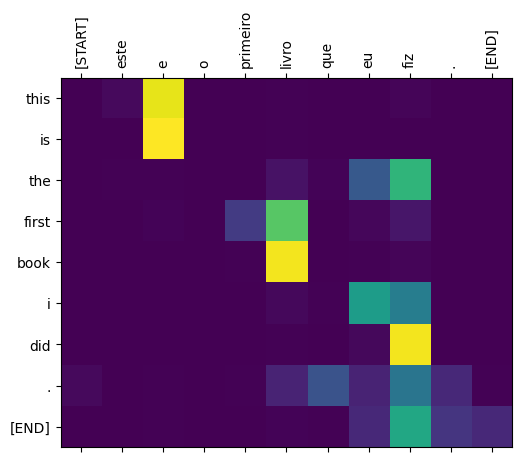

In [78]:
# 어텐션 맵 시각화
plot_attention_head(in_tokens, translated_tokens, attention)

In [79]:
#번역할 문장(sentence), 번역된 토큰(translated_tokens), 어텐션 헤드들의 가중치(attention_heads)를 입력으로 받습니다.

def plot_attention_weights(sentence, translated_tokens, attention_heads):
  # 입력 문장을 텐서로 변환하고 토큰화
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  # 시각화를 위한 그래프 설정
  fig = plt.figure(figsize=(16, 8))

  # 각 어텐션 헤드에 대한 어텐션 맵을 그래프로 표시
  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)  # 2x4 격자에 그래프 배치

    plot_attention_head(in_tokens, translated_tokens, head)  # 어텐션 헤드별 맵 그리기

    ax.set_xlabel(f'Head {h+1}')  # x축 레이블 설정

  plt.tight_layout()  # 그래프 레이아웃 조정
  plt.show()  # 그래프 표시

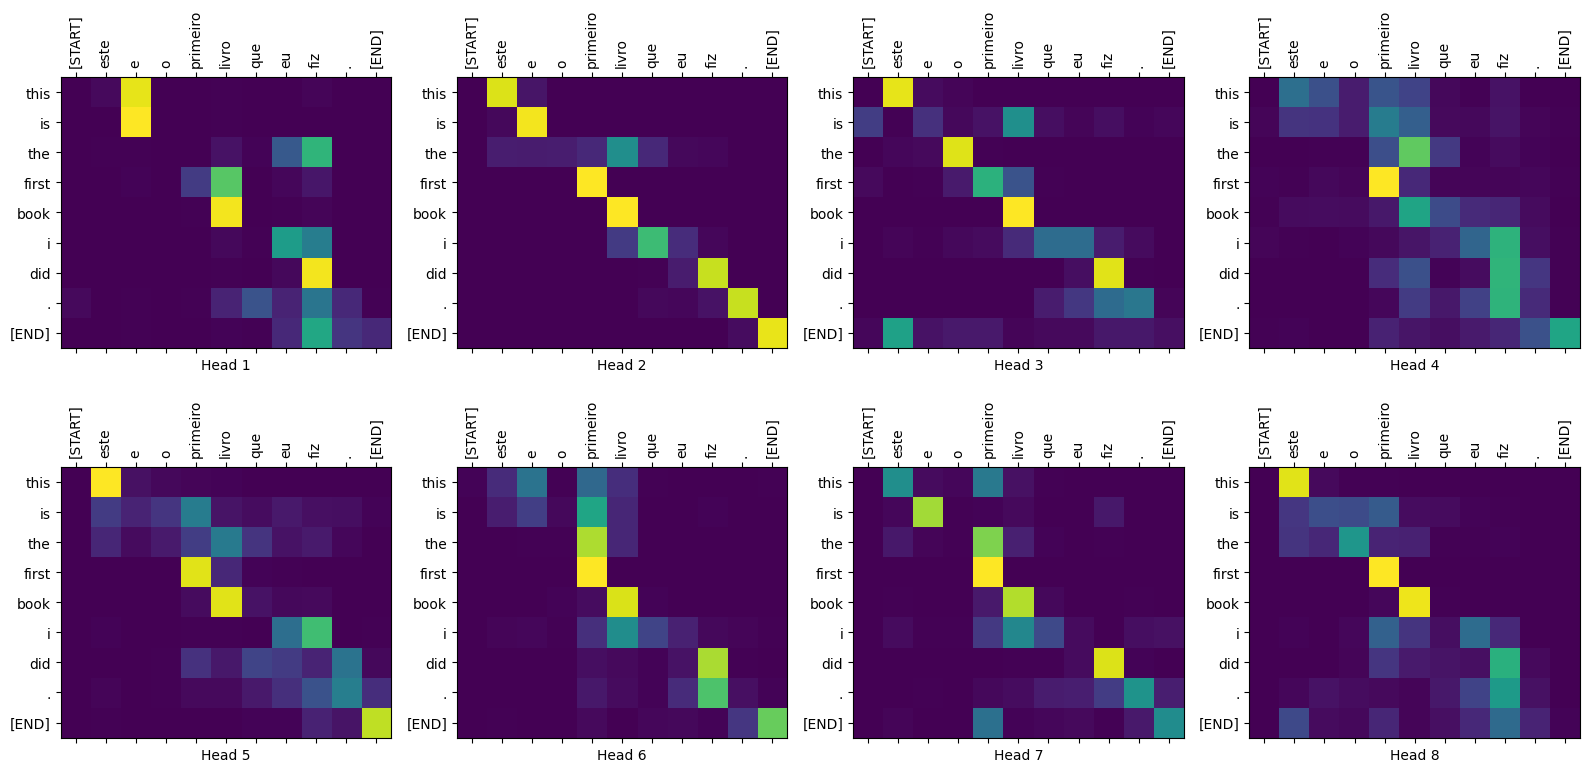

In [80]:
# 주어진 문장, 번역된 토큰, 첫 번째 어텐션 헤드의 가중치를 사용하여 어텐션 맵 시각화
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])  # 첫 번째 어텐션 헤드의 가중치

## model export

모델을 테스트했으며 추론이 작동하고 있습니다. 다음으로 `tf.saved_model`로 내보낼 수 있습니다.

In [81]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator  # 번역기 객체

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    # translator 객체를 사용하여 주어진 문장을 번역
    (result, tokens, attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result  # 번역 결과 반환

In [82]:
translator = ExportTranslator(translator)

모델이 `tf.argmax`를 사용하여 예측을 디코딩하므로 예측은 deterministic입니다. 원본 모델과 'SavedModel'에서 다시 로드된 모델은 동일한 예측을 제공해야 합니다.

In [83]:
translator('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

In [84]:
tf.saved_model.save(translator, export_dir='translator')

In [85]:
reloaded = tf.saved_model.load('translator')

In [86]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'